In [2]:
!pip install -q sklearn

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [4]:
tf.__version__

'2.5.0'

In [1]:
import pathlib

In [5]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url, extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

1671168/1668792 [==============================] - 0s 0us/step


In [6]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [7]:
dataframe['target'] = np.where(dataframe['AdoptionSpeed'] == 4, 0, 1)

dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

In [8]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,target
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,1
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,1
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,1


In [9]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print('Train samples: {}'.format(len(train)))
print('Validation samples: {}'.format(len(val)))
print('Test samples: {}'.format(len(test)))

Train samples: 7383
Validation samples: 1846
Test samples: 2308


In [13]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [14]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

In [16]:
[(train_features, label_batch)] = train_ds.take(1)

print('Every features: ', list(train_features.keys()))
print('A batch of ages: ', train_features['Age'])
print('A batch of targets: ', label_batch)

Every features:  ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages:  tf.Tensor([ 6  1 36  3  1], shape=(5,), dtype=int64)
A batch of targets:  tf.Tensor([0 1 0 1 1], shape=(5,), dtype=int64)


In [17]:
def get_normalization_layer(name, dataset):
    normalizer = preprocessing.Normalization()

    feature_ds = dataset.map(lambda x, y: x[name])

    normalizer.adapt(feature_ds)

    return normalizer

In [21]:
photo_cnt_col = train_features['PhotoAmt']
layer = get_normalization_layer('PhotoAmt', train_ds)

print(layer(photo_cnt_col))
print('Mean: {}'.format(tf.reduce_mean(layer(photo_cnt_col), axis=0)))

tf.Tensor(
[[-0.82773083]
 [-0.82773083]
 [-0.18715045]
 [-0.18715045]
 [ 2.0548809 ]], shape=(5, 1), dtype=float32)
Mean: [0.00502367]


In [25]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = preprocessing.StringLookup(max_tokens=max_tokens)
    else:
        index = preprocessing.IntegerLookup(max_tokens=max_tokens)
    
    features_ds = dataset.map(lambda x, y: x[name])
    index.adapt(features_ds)

    encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())
    
    return lambda feature: encoder(index(feature))

In [23]:
type_col = train_features['Type']
layer = get_category_encoding_layer('Type', train_ds, 'string')
layer(type_col)

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)>

In [26]:
type_col = train_features['Age']
category_encoding_layer = get_category_encoding_layer('Age', train_ds, 'int64', 5)
category_encoding_layer(type_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

In [27]:
batch_size = 256

train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [29]:
all_inputs = []
encoded_features = []

for header in ['PhotoAmt', 'Fee']:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)

    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)


age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')
encoding_layer = get_category_encoding_layer('Age', train_ds, dtype='int64', max_tokens=5)

encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']
for header in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string', max_tokens=5)

    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

In [30]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation='relu')(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, outputs)
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

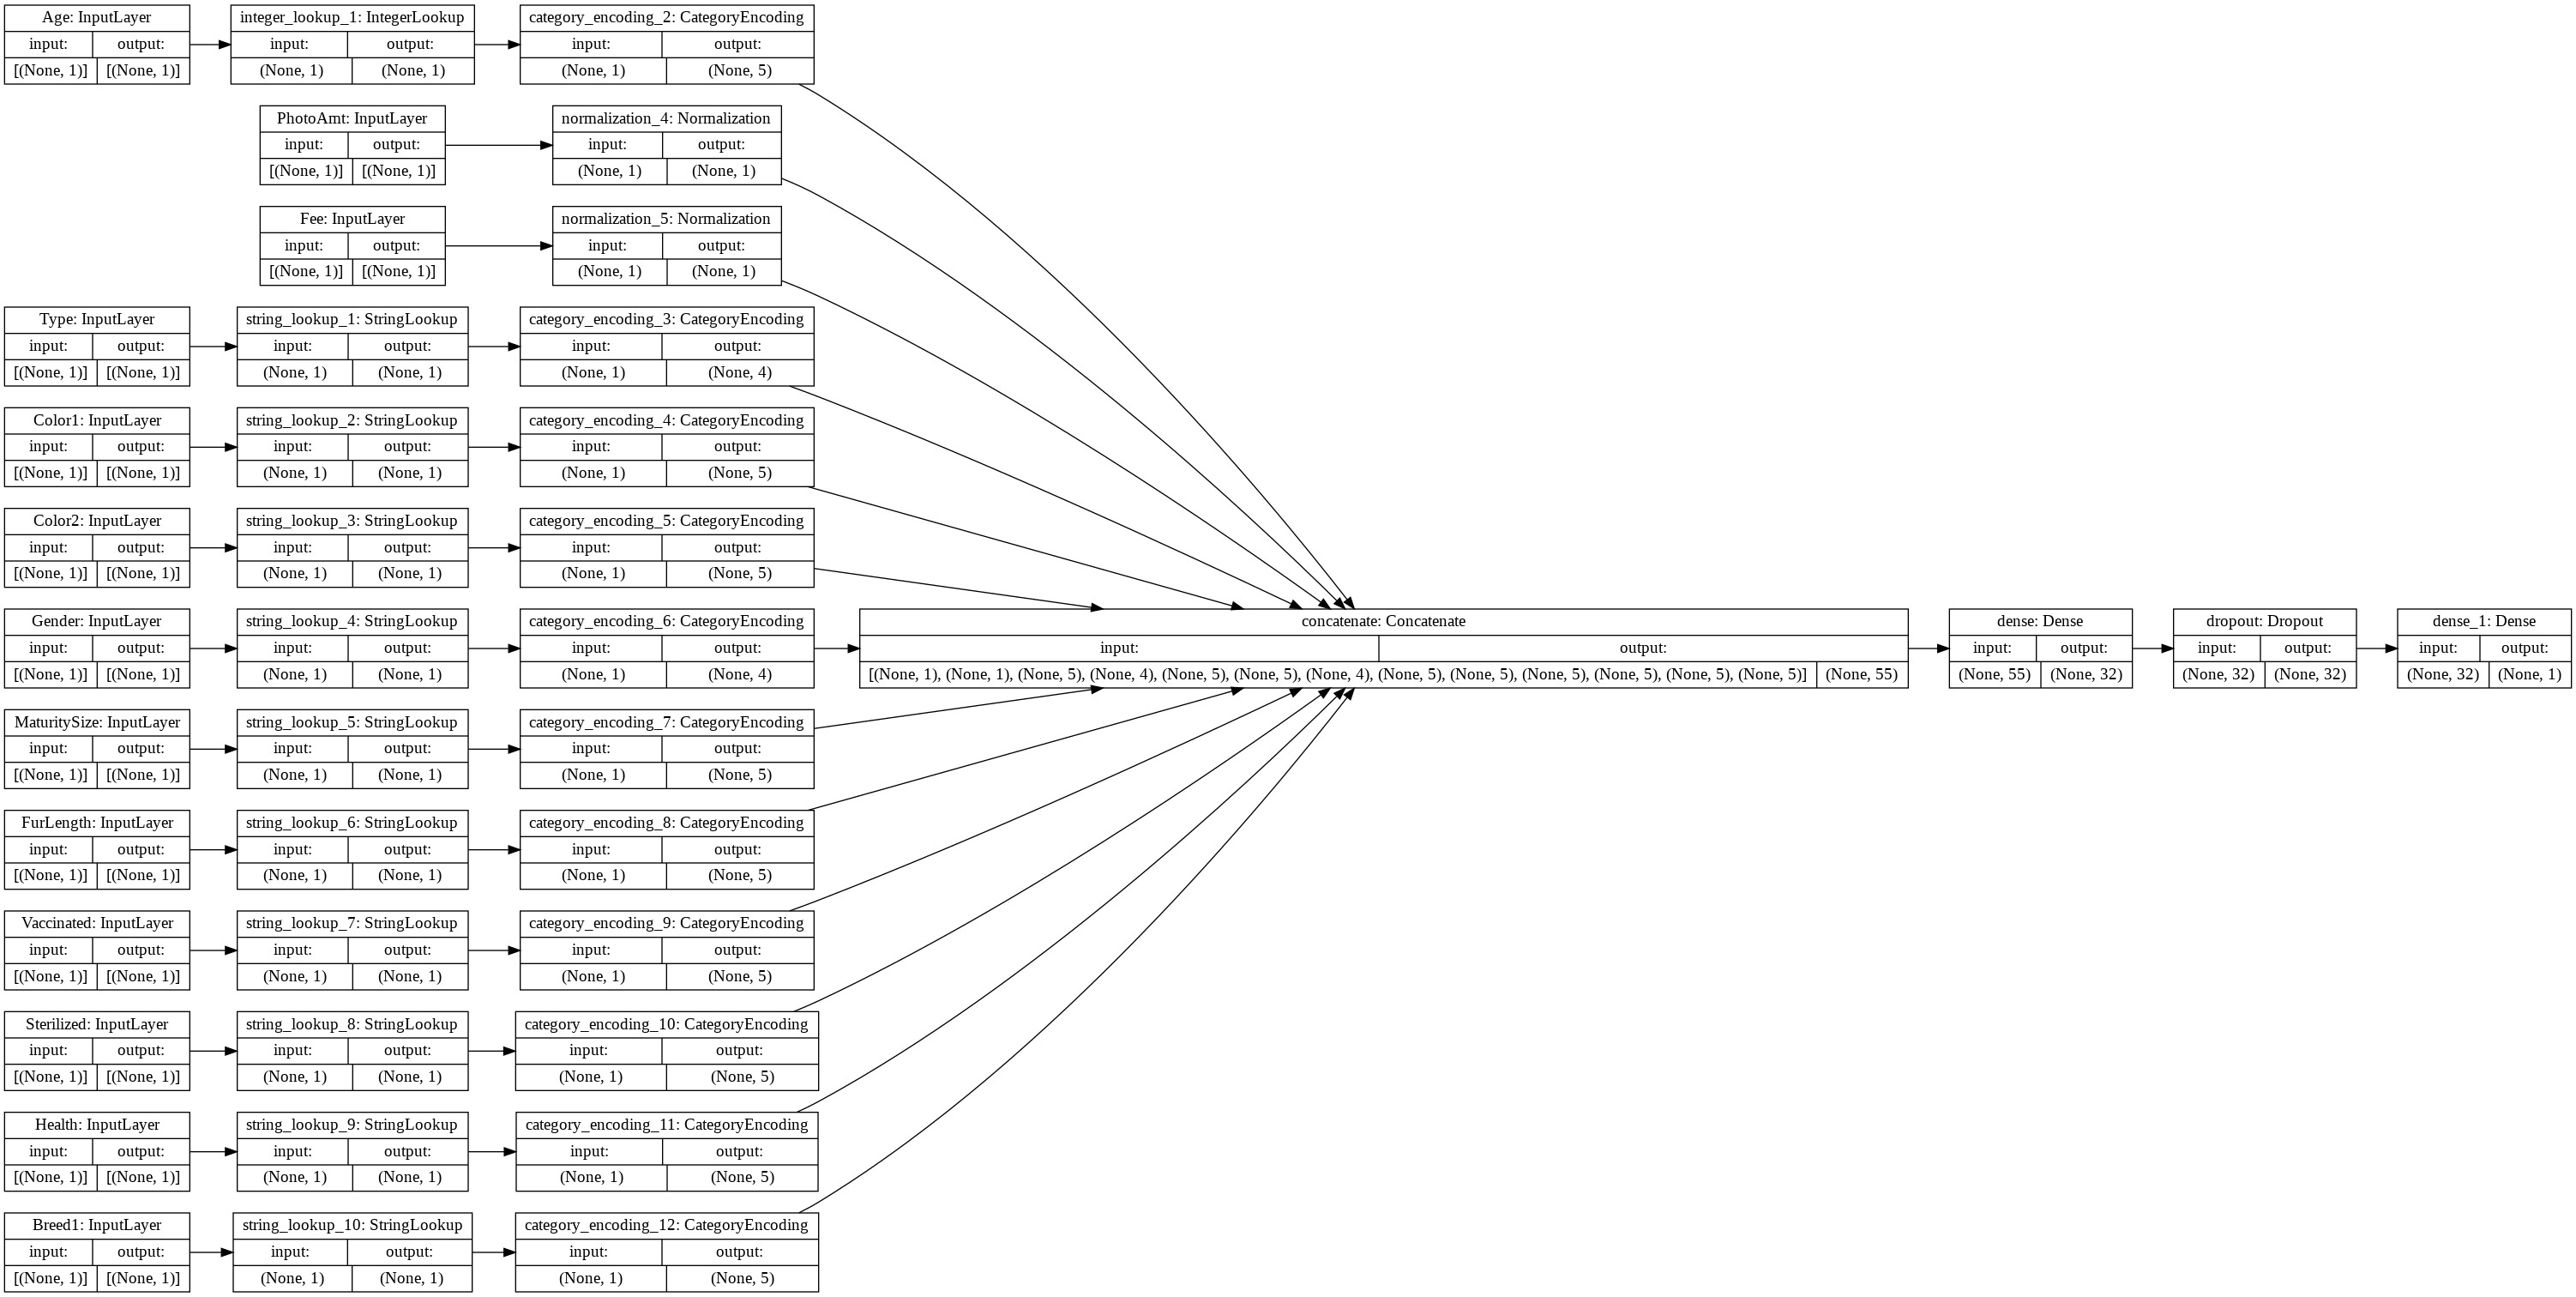

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

In [32]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
29/29 [==============================] - 2s 21ms/step - loss: 0.7351 - accuracy: 0.3746 - val_loss: 0.6017 - val_accuracy: 0.5737
Epoch 2/10
29/29 [==============================] - 0s 7ms/step - loss: 0.6011 - accuracy: 0.6141 - val_loss: 0.5763 - val_accuracy: 0.7145
Epoch 3/10
29/29 [==============================] - 0s 7ms/step - loss: 0.5731 - accuracy: 0.6702 - val_loss: 0.5656 - val_accuracy: 0.7210
Epoch 4/10
29/29 [==============================] - 0s 6ms/step - loss: 0.5589 - accuracy: 0.6875 - val_loss: 0.5570 - val_accuracy: 0.7281
Epoch 5/10
29/29 [==============================] - 0s 6ms/step - loss: 0.5542 - accuracy: 0.6982 - val_loss: 0.5500 - val_accuracy: 0.7281
Epoch 6/10
29/29 [==============================] - 0s 5ms/step - loss: 0.5491 - accuracy: 0.7040 - val_loss: 0.5455 - val_accuracy: 0.7319
Epoch 7/10
29/29 [==============================] - 0s 5ms/step - loss: 0.5395 - accuracy: 0.7016 - val_loss: 0.5426 - val_accuracy: 0.7286
Epoch 8/10
29/29 [=

In [35]:
loss, acc = model.evaluate(test_ds)
print('Acc: {}'.format(acc))

10/10 [==============================] - 0s 4ms/step - loss: 0.5247 - accuracy: 0.7175
Acc: 0.7175043225288391


In [36]:
model.save('my_pet_classifier')
reloaded_model = tf.keras.models.load_model('my_pet_classifier')

INFO:tensorflow:Assets written to: my_pet_classifier/assets


INFO:tensorflow:Assets written to: my_pet_classifier/assets


In [38]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}

predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print('The pet have %.1f percent of getting adopted.' % (prob * 100))

The pet have 84.1 percent of getting adopted.
